<a href="https://colab.research.google.com/github/Hakgyun-Hong/Algorithm/blob/master/NLP_Prediction_From_News.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import time
start = time.time()
import os

import numpy as np
import pandas as pd

from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob

#plotting
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt

#statistics & econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm

#model fiiting and selection
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor


# Data Import

In [2]:
df = pd.read_csv("/content/DataSet/Combined_News_DJIA.csv", low_memory=False, parse_dates=[0])
full_stock = pd.read_csv("/content/DataSet/upload_DJIA_table.csv", low_memory=False, parse_dates=[0])

In [3]:
df.head(5)

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",...,b'Georgia Invades South Ossetia - if Russia ge...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge"""
1,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,...,b'Israel and the US behind the Georgian aggres...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo..."
2,2008-08-12,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...",...,b'U.S. troops still in Georgia (did you know t...,b'Why Russias response to Georgia was right',"b'Gorbachev accuses U.S. of making a ""serious ...","b'Russia, Georgia, and NATO: Cold War Two'",b'Remember that adorable 62-year-old who led y...,b'War in Georgia: The Israeli connection',b'All signs point to the US encouraging Georgi...,b'Christopher King argues that the US and NATO...,b'America: The New Mexico?',"b""BBC NEWS | Asia-Pacific | Extinction 'by man..."
3,2008-08-13,0,b' U.S. refuses Israel weapons to attack Iran:...,"b""When the president ordered to attack Tskhinv...",b' Israel clears troops who killed Reuters cam...,b'Britain\'s policy of being tough on drugs is...,b'Body of 14 year old found in trunk; Latest (...,b'China has moved 10 *million* quake survivors...,"b""Bush announces Operation Get All Up In Russi...",b'Russian forces sink Georgian ships ',...,b'Elephants extinct by 2020?',b'US humanitarian missions soon in Georgia - i...,"b""Georgia's DDOS came from US sources""","b'Russian convoy heads into Georgia, violating...",b'Israeli defence minister: US against strike ...,b'Gorbachev: We Had No Choice',b'Witness: Russian forces head towards Tbilisi...,b' Quarter of Russians blame U.S. for conflict...,b'Georgian president says US military will ta...,b'2006: Nobel laureate Aleksander Solzhenitsyn...
4,2008-08-14,1,b'All the experts admit that we should legalis...,b'War in South Osetia - 89 pictures made by a ...,b'Swedish wrestler Ara Abrahamian throws away ...,b'Russia exaggerated the death toll in South O...,b'Missile That Killed 9 Inside Pakistan May Ha...,"b""Rushdie Condemns Random House's Refusal to P...",b'Poland and US agree 

In [4]:
full_stock.head(5)

,Date,Open,High,Low,Close,Volume,Adj Close
0,2016-07-01,17924.240234,18002.380859,17916.910156,17949.369141,82160000,17949.369141
1,2016-06-30,17712.759766,17930.609375,17711.800781,17929.990234,133030000,17929.990234
2,2016-06-29,17456.019531,17704.509766,17456.019531,17694.679688,106380000,17694.679688
3,2016-06-28,17190.509766,17409.720703,17190.509766,17409.720703,112190000,17409.720703
4,2016-06-27,17355.210938,17355.210938,17063.080078,17140.240234,138740000,17140.240234


In [5]:
print(df.info())
print(full_stock.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1989 entries, 0 to 1988
Data columns (total 27 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1989 non-null   datetime64[ns]
 1   Label   1989 non-null   int64         
 2   Top1    1989 non-null   object        
 3   Top2    1989 non-null   object        
 4   Top3    1989 non-null   object        
 5   Top4    1989 non-null   object        
 6   Top5    1989 non-null   object        
 7   Top6    1989 non-null   object        
 8   Top7    1989 non-null   object        
 9   Top8    1989 non-null   object        
 10  Top9    1989 non-null   object        
 11  Top10   1989 non-null   object        
 12  Top11   1989 non-null   object        
 13  Top12   1989 non-null   object        
 14  Top13   1989 non-null   object        
 15  Top14   1989 non-null   object        
 16  Top15   1989 non-null   object        
 17  Top16   1989 non-null   object        
 18  Top17   

In [6]:
df["Close"]=full_stock.Close

In [7]:
df = df.drop(["Label"],axis=1)

# Data Cleaning

## NA Treatment

In [8]:
df.isnull().sum()

Date     0
Top1     0
Top2     0
Top3     0
Top4     0
Top5     0
Top6     0
Top7     0
Top8     0
Top9     0
Top10    0
Top11    0
Top12    0
Top13    0
Top14    0
Top15    0
Top16    0
Top17    0
Top18    0
Top19    0
Top20    0
Top21    0
Top22    0
Top23    1
Top24    3
Top25    3
Close    0
dtype: int64

In [9]:
# There are few headlines missing. Fill them in with a whitespace
df = df.replace(np.nan, ' ',regex = True)
df.isnull().sum().sum()

0

## Remove the HTML tags

- There are several non-word tags in the headlines that would just bias the sentiment analysis so we need to remove them and replace with 'space'. This can be done with regex.

In [10]:
df = df.replace('b\"|b\'|\\\\|\\\"','',regex=True)
df.head(2)

,Date,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,...,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25,Close
0,2008-08-08,Georgia 'downs two Russian warplanes' as count...,BREAKING: Musharraf to be impeached.',Russia Today: Columns of troops roll into Sout...,Russian tanks are moving towards the capital o...,"Afghan children raped with 'impunity,' U.N. of...",150 Russian tanks have entered South Ossetia w...,"Breaking: Georgia invades South Ossetia, Russi...",The 'enemy combatent' trials are nothing but a...,Georgian troops retreat from S. Osettain capit...,...,Al-Qaeda Faces Islamist Backlash',Condoleezza Rice: The US would not act to prev...,This is a busy day: The European Union has ap...,"Georgia will withdraw 1,000 soldiers from Iraq...",Why the Pentagon Thinks Attacking Iran is a Ba...,Caucasus in crisis: Georgia invades South Osse...,Indian shoe manufactory - And again in a seri...,Visitors Suffering from Mental Illnesses Banne...,No Help for Mexico's Kidnapping Surge,17949.369141
1,2008-08-11,Why wont America and Nato help us? If they won...,Bush puts foot down on Georgian conflict',Jewish Georgian minister: Thanks to Israeli tr...,Georgian army flees in disarray as Russians ad...,Olympic opening ceremony fireworks 'faked',What were the Mossad with fraudulent New Zeala...,Russia angered by Israeli military sale to Geo...,An American citizen living in S.Ossetia blames...,Welcome To World War IV! Now In High Definition!',...,"Do not believe TV, neither Russian nor Georgia...",Riots are still going on in Montreal (Canada) ...,China to overtake US as largest manufacturer',War in South Ossetia [PICS]',Israeli Physicians Group Condemns State Torture',Russia has just beaten the United States over...,Perhaps *the* question about the Georgia - Rus...,Russia is so much better at war',So this is what it's come to: trading sex for ...,17929.990234


# Sentiment and subjectivity score extraction

- in here, I will run the sentiment analysis extracting the compund score that goes from -0.5(Negative) ~ +0.5(Positive). I'm going to use the dirry texts in this part Because VADER can utilize the information such as ALL CAPS, punctuation, etc. This will also calculate the subjectivity of each headline of each headline using the TextBlob package

In [11]:
import nltk
nltk.download("vader_lexicon")

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

* SentimentIntensityAnalyzer will analyze sentimentality of sentence. In this code, for instance, used just 'white space' sentiment contains 3 types.
> - negative 
> - neutral
> - positive
> - And print Compound

In [12]:
Anakin = SentimentIntensityAnalyzer()
Anakin.polarity_scores(" ")

{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0}

- Polarity is a float value within the range [-1.0 to 1.0] where 0 indicates neutral, +1 indicates a very positive sentiment and -1 represents a very negative sentiment.

- Subjectivity is a float value within the range [0.0 to 1.0] where 0.0 is very objective and 1.0 is very subjective. Subjective sentence expresses some personal feelings, views, beliefs, opinions, allegations, desires, beliefs, suspicions, and speculations where as Objective sentences are factual.

In [13]:
def detect_subjectivity(text):
  return TextBlob(text).sentiment.subjectivity

detect_subjectivity(" ") # should return 0

0.0

# Get Data

## get the headline column names

In [14]:

cols = []
for i in range(1,26):
    col = ("Top{}".format(i))
    cols.append(col)

In [15]:
start_vect = time.time()
print("ANAKIN: 'initializing the process..'")

cols = []
for i in range(1,26):
    col = ("Top{}".format(i))
    cols.append(col)


for col in cols:
  df[col] = df[col].astype(str)
  df[col+'_comp'] = df[col].apply(lambda x:Anakin.polarity_scores(x)['compound'])
  # lambda 입력변수 : 리턴값
  df[col+'_sub'] = df[col].apply(detect_subjectivity)
  print("{} Done".format(col))

print("VADER: Vaderization completed after %0.2f Minutes" % (( time.time()-start_vect)/60 ))


ANAKIN: 'initializing the process..'
Top1 Done
Top2 Done
Top3 Done
Top4 Done
Top5 Done
Top6 Done
Top7 Done
Top8 Done
Top9 Done
Top10 Done
Top11 Done
Top12 Done
Top13 Done
Top14 Done
Top15 Done
Top16 Done
Top17 Done
Top18 Done
Top19 Done
Top20 Done
Top21 Done
Top22 Done
Top23 Done
Top24 Done
Top25 Done
VADER: Vaderization completed after 0.91 Minutes


In [16]:
df = df.drop(cols, axis=1)
df.head(5)

,Date,Close,Top1_comp,Top1_sub,Top2_comp,Top2_sub,Top3_comp,Top3_sub,Top4_comp,Top4_sub,...,Top21_comp,Top21_sub,Top22_comp,Top22_sub,Top23_comp,Top23_sub,Top24_comp,Top24_sub,Top25_comp,Top25_sub
0,2008-08-08,17949.369141,-0.5994,0.0,0.0000,0.000000,-0.3612,0.000000,-0.7089,0.200000,...,-0.7579,0.666667,-0.6249,0.0,-0.2755,0.00,-0.8519,0.200000,0.1280,0.0
1,2008-08-11,17929.990234,0.8156,0.0,-0.3182,0.288889,0.4404,0.100000,-0.1965,0.000000,...,-0.8020,0.000000,0.0000,0.0,-0.3182,0.00,-0.1832,0.500000,0.0000,0.0
2,2008-08-12,17694.679688,0.0258,1.0,0.0000,0.000000,-0.7845,0.833333,-0.6124,1.000000,...,-0.5994,0.000000,0.5267,0.0,0.3818,0.35,0.0000,0.454545,0.0000,0.0
3,2008-08-13,17409.720703,-0.7184,0.0,-0.8074,0.000000,-0.6369,0.000000,-0.1280,0.444444,...,-0.2960,0.000000,0.4939,0.0,-0.5719,0.00,-0.4215,0.100000,-0.3400,0.0
4,2008-08-14,17140.240234,0.2023,0.0,-0.5994,0.000000,0.6808,0.400000,-0.8689,0.666667,...,-0.4404,0.000000,-0.5994,0.0,0.1779,0.00,-0.6908,0.500000,0.7096,0.0


In [17]:
df.columns

Index(['Date', 'Close', 'Top1_comp', 'Top1_sub', 'Top2_comp', 'Top2_sub',
       'Top3_comp', 'Top3_sub', 'Top4_comp', 'Top4_sub', 'Top5_comp',
       'Top5_sub', 'Top6_comp', 'Top6_sub', 'Top7_comp', 'Top7_sub',
       'Top8_comp', 'Top8_sub', 'Top9_comp', 'Top9_sub', 'Top10_comp',
       'Top10_sub', 'Top11_comp', 'Top11_sub', 'Top12_comp', 'Top12_sub',
       'Top13_comp', 'Top13_sub', 'Top14_comp', 'Top14_sub', 'Top15_comp',
       'Top15_sub', 'Top16_comp', 'Top16_sub', 'Top17_comp', 'Top17_sub',
       'Top18_comp', 'Top18_sub', 'Top19_comp', 'Top19_sub', 'Top20_comp',
       'Top20_sub', 'Top21_comp', 'Top21_sub', 'Top22_comp', 'Top22_sub',
       'Top23_comp', 'Top23_sub', 'Top24_comp', 'Top24_sub', 'Top25_comp',
       'Top25_sub'],
      dtype='object')

In [18]:
comp_cols = []
for col in cols:
  comp_col = col+"_comp"
  comp_cols.append(comp_col)

w= np.arange(1,26,1).tolist()
w.reverse()

weighted_comp = []
max_comp = []
min_comp = []
for i in range(0,len(df)):
  a = df.loc[i,comp_cols].tolist()
  weighted_comp.append(np.average(a,weights=w))
  max_comp.append(max(a))
  min_comp.append(min(a))

df['compound_mean'] = weighted_comp
df['compound_max'] = max_comp
df['compound_min'] = min_comp

sub_cols = []

for col in cols:
  sub_col = col+ "_sub"
  sub_cols.append(sub_col)

weighted_sub = []
max_sub = []
min_sub = []

for i in range(0,len(df)):
  a = df.loc[i,sub_cols].to_list()
  weighted_sub.append(np.average(a,weights =w))
  max_sub.append(max(a))
  min_sub.append(min(a))

df['subjectivity_mean'] = weighted_sub
df['subjectivity_max'] = max_sub
df['subjectivity_min'] = min_sub

to_drop = sub_cols + comp_cols
df = df.drop(to_drop, axis=1)

In [19]:
df.head(5)

,Date,Close,compound_mean,compound_max,compound_min,subjectivity_mean,subjectivity_max,subjectivity_min
0,2008-08-08,17949.369141,-0.350337,0.2144,-0.9260,0.163685,0.666667,0.0
1,2008-08-11,17929.990234,-0.085277,0.8156,-0.8271,0.202921,0.720000,0.0
2,2008-08-12,17694.679688,-0.318394,0.5423,-0.8591,0.374076,1.000000,0.0
3,2008-08-13,17409.720703,-0.162032,0.5106,-0.8074,0.176371,0.900000,0.0
4,2008-08-14,17140.240234,-0.194879,0.7177,-0.8689,0.319615,1.000000,0.0


- Each day have compound and subjectivity. So we divide it

# Explorative Data Analysis
- First the timeseries of the y variable will be explored.
- It is likely the timeseries isnt stationary which however doesnt worry us in this case as the models wont be f the classical timeseries methods family.

In [20]:
fig1 = go.Figure()
fig1.add_trace(go.Scatter(x=df.Date, y=df.Close, mode='lines'))

title = []
title.append(dict(xref = 'paper', yref = 'paper', x=0.0, y=1.05, xanchor='left', yanchor= 'bottom', text = 'Development of stock values from Aug, 2008 to Jun, 2016',
                  font = dict(family = 'Arial', size=30, color ='rgb(37,37,37)'), showarrow=False))
fig1.update_layout(xaxis_title='Date', yaxis_title='Closing stock value (in $)', annotations = title)
fig1.show()

In [21]:
def stationary_plot(y, lags= None, figsize=(12,7), style='bmh'):
  if not isinstance(y, pd.Series):
    y = pd.Series(y)
  with plt.style.context(style):
    fig = plt.figure(figsize=figsize)
    layout=(2,2)
    ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
    acf_ax = plt.subplot2grid(layout,(1,0))
    pacf_ax = plt.subplot2grid(layout,(1,1))

    y.plot(ax = ts_ax)
    p_value = sm.tsa.stattools.adfuller(y)[1]
    ts_ax.set_title('Time Series Analysis Plots\n Dickey_fuller: p={0:.5f}'.format(p_value))
    smt.graphics.plot_acf(y,lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y,lags=lags, ax=pacf_ax)
    plt.tight_layout()

- plot_acf : Autocorrelation Function(자기상관함수)
- plot_pacf

/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



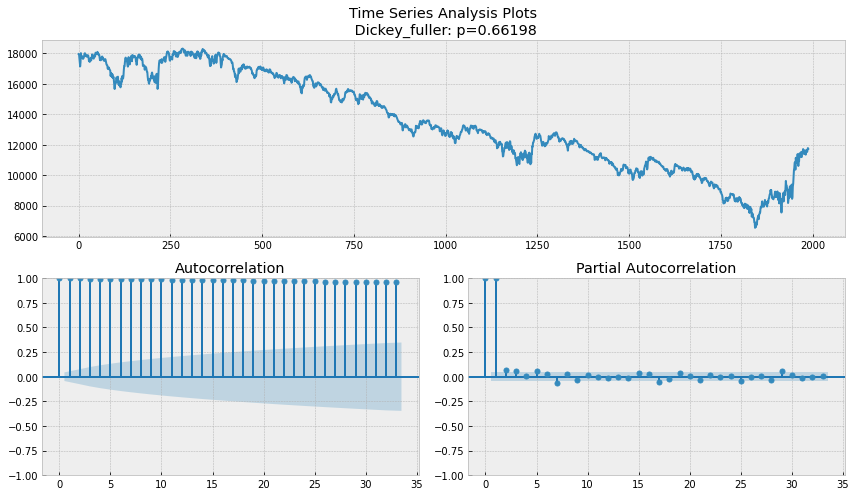

In [22]:
stationary_plot(df.Close)

> - If we see this result. Autocorrelation have out range of blue area. So this data have Autocorrelation.

> - So that is very unstationary timeseries. Although we won't need it for our models it might still be interesting try to make the data stationary. Challenge accepted.

/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



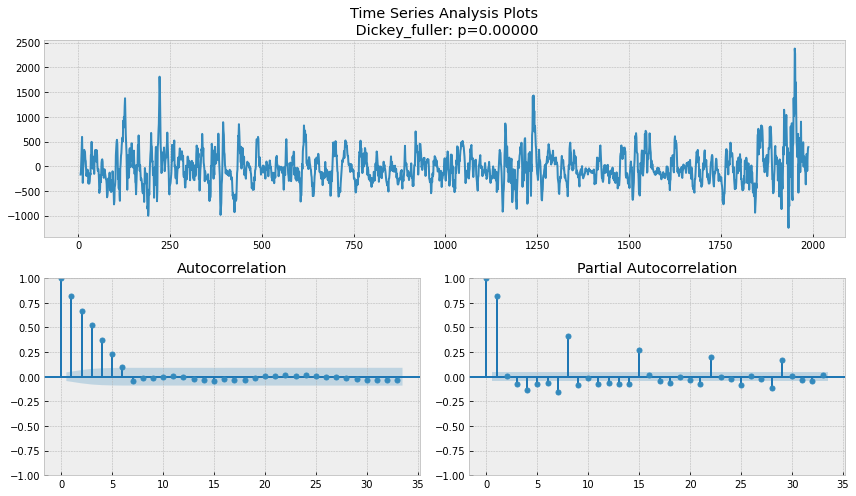

In [23]:
diff = df.Close - df.Close.shift(7)
stationary_plot(diff[7:])

> - This  seems that removing **weekly seasonality** helped a bit but the autocorrelation plot still shows many significant lags.

/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



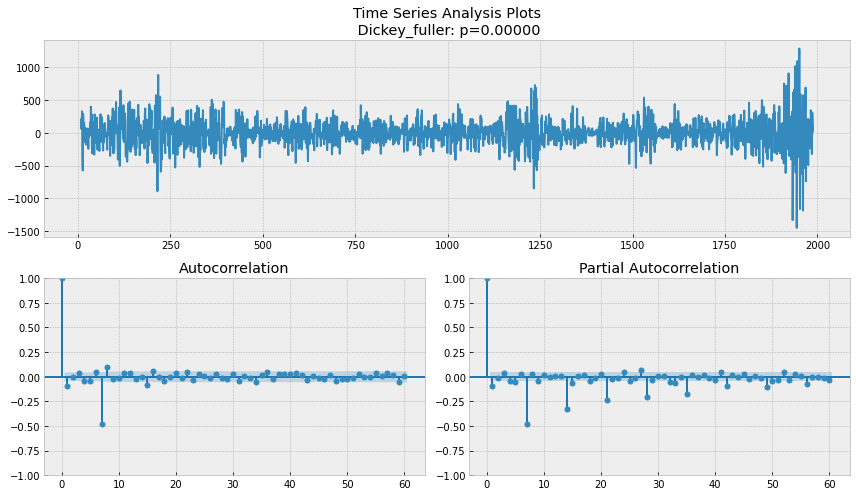

In [24]:
diff2 = diff - diff.shift(1)
stationary_plot(diff2[7+1:], lags=60)

> - Now this is a relatively stationary. Well it is something oscilating around zero. From these plots  the parameters for a SARIMA model can be inferred. However, this is for now beyond the scope of this kernel.

In [25]:
fig2 = go.Figure()
fig2.add_trace(go.Scatter(x=df.Date, y=df.compound_mean,
                          mode='lines',
                          name='Mean'))
fig2.add_trace(go.Scatter(x=df.Date, y=df.compound_max,
                          mode='lines',
                          name='Maximum'))
fig2.add_trace(go.Scatter(x=df.Date, y=df.compound_min,
                          mode='lines',
                          name='Minimum'))
title=[]
title.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                  xanchor = 'left', yanchor='bottom',
                  text = 'Development of sentiment compound score',
                  font=dict(family='Arial', size=30,color ='rgb(37,37,37)'),
                  showarrow=False))
fig2.update_layout(xaxis_title='Date',
                   yaxis_title='Compound score',
                   annotations=title)
fig2.show()

## Compound score

In [26]:
compm_hist = px.histogram(df,x="compound_mean")
compm_hist.show()

## Subjectivity score

In [27]:
fig3 = go.Figure()
fig3.add_trace(go.Scatter(x=df.Date, y=df.subjectivity_mean,
                          mode = 'lines',
                          name = 'Mean'))
fig3.add_trace(go.Scatter(x=df.Date, y=df.subjectivity_min,
                          mode='lines',
                          name='Min'))
fig3.add_trace(go.Scatter(x=df.Date, y=df.subjectivity_max,
                          mode='lines',
                          name='Max'))

title=[]
title.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                  xanchor = 'left', yanchor='bottom',
                  text = 'Development of subjectivity score',
                  font=dict(family='Arial',
                            size=30,
                            color = 'rgb(37,37,37)'),
                  showarrow=False))

fig3.update_layout(xaxis_title='Date',
                   yaxis_title='Subjectivity score',
                   annotations=title)
fig3.show()


In [28]:
subm_hist = px.histogram(df, x="subjectivity_mean")
subm_hist.show()

In [29]:
df.describe()

,Close,compound_mean,compound_max,compound_min,subjectivity_mean,subjectivity_max,subjectivity_min
count,1989.000000,1989.000000,1989.000000,1989.000000,1989.000000,1989.000000,1989.0
mean,13463.032255,-0.213180,0.656593,-0.885705,0.251779,0.892645,0.0
std,3144.006996,0.106652,0.165660,0.062681,0.066196,0.144796,0.0
min,6547.049805,-0.546383,0.000000,-0.989800,0.080897,0.416667,0.0
25%,10913.379883,-0.283282,0.542300,-0.931300,0.205581,0.785714,0.0
50%,13025.580078,-0.210306,0.670500,-0.897900,0.249927,1.000000,0.0
75%,16478.410156,-0.140874,0.784500,-0.851900,0.297009,1.000000,0.0
max,18312.390625,0.166370,0.962300,-0.571900,0.470498,1.000000,0.0


# Feature Selection

In [30]:
def unique_ratio(col):
  return len(np.unique(col))/len(col)

In [31]:
cols = ['Close', 'compound_mean', 'compound_max', 'compound_min','subjectivity_mean','subjectivity_max','subjectivity_min']

ur = []
var = []
for col in cols:
  ur.append(unique_ratio(df[col]))
  var.append(np.var(df[col]))

feature_sel = pd.DataFrame({'Column':cols,
                            'Unique':ur,
                            'Variance':var})
feature_sel

,Column,Unique,Variance
0,Close,0.994470,9.879810e+06
1,compound_mean,1.000000,1.136883e-02
2,compound_max,0.191051,2.742928e-02
3,compound_min,0.179487,3.926918e-03
4,subjectivity_mean,0.999497,4.379750e-03
5,subjectivity_max,0.083962,2.095546e-02
6,subjectivity_min,0.000503,0.000000e+00


In [32]:
sel_fig = go.Figure(data=go.Scatter(x=feature_sel.Column, y=feature_sel.Unique, mode = 'markers', marker=dict(size=(feature_sel.Unique*100)),
                                    ))
sel_fig.update_layout(title='Ratio of unique values',
                      yaxis_title='Unique ratio')
sel_fig.show()

- Compound_max and compound_min are potentially less interesting as only ~18% of their values are unique.

In [33]:
drop = ['subjectivity_min', 'subjectivity_max']
clean_df = df.drop(drop,axis=1)

# Lag the extracted features

- To allow the models to look into the past, we will add features which are essentially just copies of rows from n-steps back. In order to not create too many new features we will add only features from 1 week prior to the current datapoint.

In [34]:
lag_df = clean_df.copy()
lag_df.head(3)

,Date,Close,compound_mean,compound_max,compound_min,subjectivity_mean
0,2008-08-08,17949.369141,-0.350337,0.2144,-0.9260,0.163685
1,2008-08-11,17929.990234,-0.085277,0.8156,-0.8271,0.202921
2,2008-08-12,17694.679688,-0.318394,0.5423,-0.8591,0.374076


In [35]:
to_lag = list(lag_df.columns)
to_lag_4 = to_lag[1]
to_lag_1 = to_lag[2:len(to_lag)]

In [36]:
#lagging text features two days back
for col in to_lag_1:
  for i in range(1,3):
    new_name = col + ('_lag_{}'.format(i))
    lag_df[new_name] = lag_df[col].shift(i)

#lagging closing valeus 4 days back
for i in range(1,5):
  new_name = to_lag_4 + ('_lag_{}'.format(i))
  lag_df[new_name] = lag_df[to_lag_4].shift(i)

In [37]:
lag_df.head(10)

,Date,Close,compound_mean,compound_max,compound_min,subjectivity_mean,compound_mean_lag_1,compound_mean_lag_2,compound_max_lag_1,compound_max_lag_2,compound_min_lag_1,compound_min_lag_2,subjectivity_mean_lag_1,subjectivity_mean_lag_2,Close_lag_1,Close_lag_2,Close_lag_3,Close_lag_4
0,2008-08-08,17949.369141,-0.350337,0.2144,-0.9260,0.163685,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2008-08-11,17929.990234,-0.085277,0.8156,-0.8271,0.202921,-0.350337,NaN,0.2144,NaN,-0.9260,NaN,0.163685,NaN,17949.369141,NaN,NaN,NaN
2,2008-08-12,17694.679688,-0.318394,0.5423,-0.8591,0.374076,-0.085277,-0.350337,0.8156,0.2144,-0.8271,-0.9260,0.202921,0.163685,17929.990234,17949.369141,NaN,NaN
3,2008-08-13,17409.720703,-0.162032,0.5106,-0.8074,0.176371,-0.318394,-0.085277,0.5423,0.8156,-0.8591,-0.8271,0.374076,0.202921,17694.679688,17929.990234,17949.369141,NaN
4,2008-08-14,17140.240234,-0.194879,0.7177,-0.8689,0.319615,-0.162032,-0.318394,0.5106,0.5423,-0.8074,-0.8591,0.176371,0.374076,17409.720703,17694.679688,17929.990234,17949.369141
5,2008-08-15,17400.750000,-0.138013,0.4404,-0.7481,0.227282,-0.194879,-0.162032,0.7177,0.5106,-0.8689,-0.8074,0.319615,0.176371,17140.240234,17409.720703,17694.679688,17929.990234
6,2008-08-18,18011.070312,-0.263546,0.5106,-0.9260,0.216935,-0.138013,-0.194879,0.4404,0.7177,-0.7481,-0.8689,0.227282,0.319615,17400.750000,17140.240234,17409.720703,17694.679688
7,2008-08-19,17780.830078,-0.373172,0.5574,-0.8720,0.256786,-0.263546,-0.138013,0.5106,0.4404,-0.9260,-0.7481,0.216935,0.227282,18011.070312,17400.750000,17140.240234,17409.720703
8,2008-08-20,17829.730469,-0.197157,0.4847,-0.8807,0.095403,-0.373172,-0.263546,0.5574,0.5106,-0.8720,-0.9260,0.256786,0.216935,17780.830078,18011.070312,17400.750000,17140.240234
9,2008-08-21,17804.869141,-0.268522,0.5719,-0.9022,0.107994,-0.197157,-0.373172,0.4847,0.5574,-0.8807,-0.8720,0.095403,0.256786,17829.730469,17780.830078,18011.070312,17400.750000


- Drop index 0~3

In [38]:
lag_df = lag_df.drop(lag_df.index[[np.arange(0,4)]])
lag_df = lag_df.reset_index(drop=True)

lag_df.isnull().sum().sum()

/usr/local/lib/python3.8/dist-packages/pandas/core/indexes/base.py:4616: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



0

In [39]:
lag_df.head(5)

,Date,Close,compound_mean,compound_max,compound_min,subjectivity_mean,compound_mean_lag_1,compound_mean_lag_2,compound_max_lag_1,compound_max_lag_2,compound_min_lag_1,compound_min_lag_2,subjectivity_mean_lag_1,subjectivity_mean_lag_2,Close_lag_1,Close_lag_2,Close_lag_3,Close_lag_4
0,2008-08-14,17140.240234,-0.194879,0.7177,-0.8689,0.319615,-0.162032,-0.318394,0.5106,0.5423,-0.8074,-0.8591,0.176371,0.374076,17409.720703,17694.679688,17929.990234,17949.369141
1,2008-08-15,17400.750000,-0.138013,0.4404,-0.7481,0.227282,-0.194879,-0.162032,0.7177,0.5106,-0.8689,-0.8074,0.319615,0.176371,17140.240234,17409.720703,17694.679688,17929.990234
2,2008-08-18,18011.070312,-0.263546,0.5106,-0.9260,0.216935,-0.138013,-0.194879,0.4404,0.7177,-0.7481,-0.8689,0.227282,0.319615,17400.750000,17140.240234,17409.720703,17694.679688
3,2008-08-19,17780.830078,-0.373172,0.5574,-0.8720,0.256786,-0.263546,-0.138013,0.5106,0.4404,-0.9260,-0.7481,0.216935,0.227282,18011.070312,17400.750000,17140.240234,17409.720703
4,2008-08-20,17829.730469,-0.197157,0.4847,-0.8807,0.095403,-0.373172,-0.263546,0.5574,0.5106,-0.8720,-0.9260,0.256786,0.216935,17780.830078,18011.070312,17400.750000,17140.240234


# Model Training

**Models**

- Ridge regression
- Random Forest
- XGBoost

In [41]:
tscv = TimeSeriesSplit(n_splits=10)

In [54]:
def mape(y_true, y_pred):
  return np.mean(np.abs((y_true-y_pred)/y_true))*100

scorer = make_scorer(mean_squared_error)
scaler = StandardScaler()

In [42]:
def ts_train_test_split(X,y,test_size):
  test_index = int(len(X)*(1-test_size))

  X_train = X.iloc[:test_index]
  y_train = y.iloc[:test_index]
  X_test = X.iloc[test_index:]
  y_test = y.iloc[test_index:]

  return X_train, X_test, y_train, y_test

In [46]:
X = lag_df.drop(['Close'], axis =1)
X.index = X["Date"]


In [47]:
X = X.drop(["Date"], axis=1)
y = lag_df.Close

In [48]:
X_train, X_test, y_train, y_test = ts_train_test_split(X, y, test_size = 0.2)

In [49]:
#Sanity Check
(len(X_train)+len(X_test))==len(X)

True

In [50]:
# Function for plotting coefficients of modlels (Lasso and XGBoost)
def plotCoef(model, train_X):
  coefs = pd.DataFrame(model.coef_,train_X.columns)
  coefs.columns = ["coef"]
  coefs["abs"] = coefs.coef.apply(np.abs)
  coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"],axis=1)

  plt.figure(figsize=(15,7))
  coefs.coef.plot(kind='bar')
  plt.grid(True, axis='y')
  plt.hlines(y=0,xmin=0,xmax=len(coefs), linestyles='dashed');
  

# Econometric Models

In [51]:
econ_cols = list(X_train.columns)
econ_cols = econ_cols[12:17]
X_train_e = X_train[econ_cols]
X_test_e = X_test[econ_cols]
y_train_e = y_train
y_test_e = y_test

In [52]:
econ_perf = pd.DataFrame(columns = ['Model','MSE','SD'])
econ_perf

,Model,MSE,SD


## Ridge regression

In [55]:
ridge_param = {'model__alpha':list(np.arange(0.001,1,0.001))}
ridge = Ridge(max_iter=5000)
pipe = Pipeline([
    ('scale',scaler),
    ('model',ridge)
])

search_ridge = GridSearchCV(estimator=pipe,
                            param_grid = ridge_param,
                            scoring=scorer,
                            cv= tscv,
                            n_jobs=4)
search_ridge.fit(X_train_e,y_train_e)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('model', Ridge(max_iter=5000))]),
             n_jobs=4,
             param_grid={'model__alpha': [0.001, 0.002, 0.003, 0.004, 0.005,
                                          0.006, 0.007, 0.008,
                                          0.009000000000000001,
                                          0.010000000000000002, 0.011, 0.012,
                                          0.013000000000000001,
                                          0.014000000000000002, 0.015, 0.016,
                                          0.017, 0.018000000000000002,
                                          0.019000000000000003, 0.02, 0.021,
                                          0.022000000000000002, 0.023, 0.024,
                                          0.025, 0.026000000000000002,
                                          0.027000000000000003, 0.028, 0.029,
                                          0.030000000000000002, ...]},
             scoring=make_scorer(mean_squared_error))

In [56]:
ridge_e = search_ridge.best_estimator_

from sklearn.model_selection import cross_val_score
cv_score = cross_val_score(ridge_e, X_train_e, y_train_e, cv = tscv, scoring=scorer)
econ_perf = econ_perf.append({'Model':'Ridge','MSE':np.mean(cv_score), 'SD':(np.std(cv_score))}, ignore_index=True)

ridge_e

Pipeline(steps=[('scale', StandardScaler()),
                ('model', Ridge(alpha=0.999, max_iter=5000))])

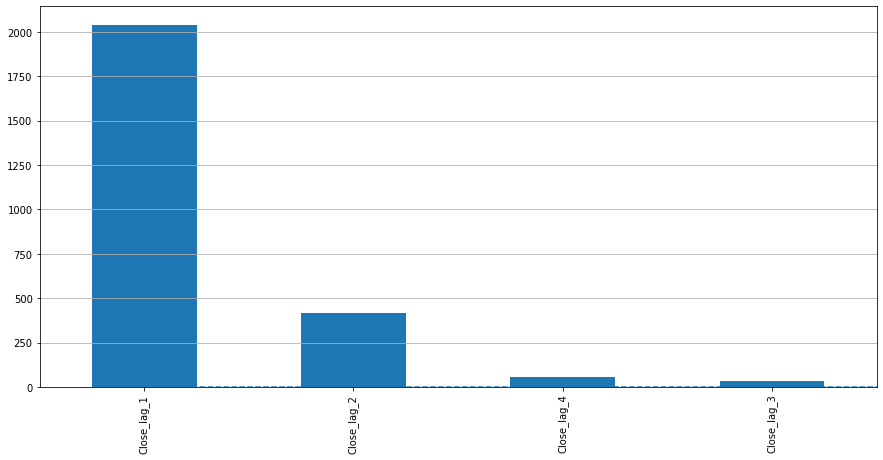

In [57]:
plotCoef(ridge_e['model'], X_train_e)

In [59]:
coefs = ridge_e['model'].coef_
ridge_coefs = pd.DataFrame({'Coef':coefs, 'Name':list(X_train_e.columns)})

ridge_coefs ["abs"] = ridge_coefs.Coef.apply(np.abs)
ridge_coefs = ridge_coefs.sort_values(by="abs", ascending = False).drop(["abs"], axis=1)
ridge_coefs

,Coef,Name
0,2041.601673,Close_lag_1
1,414.480793,Close_lag_2
3,58.219956,Close_lag_4
2,30.646149,Close_lag_3


In [60]:
econ_perf

,Model,MSE,SD
0,Ridge,16148.54356,8475.253033


## Random Forest

In [61]:
rf_param = {'model__n_estimators': [10,100,300],
            'model__max_depth' : [10,20,30,40],
            'model__min_samples_split':[2,5,10],
            'model__min_samples_leaf':[1,2,3],
            'model__max_features':["auto",'sqrt']}

In [62]:
rf = RandomForestRegressor()
pipe = Pipeline([
    ('scale', scaler),
    ('model', rf)
])

gridsearch_rf = GridSearchCV(estimator=pipe,
                             param_grid = rf_param,
                             scoring = scorer,
                             cv=tscv,
                             n_jobs=4,
                             verbose=3)

In [63]:
gridsearch_rf.fit(X_train_e, y_train_e)

Fitting 10 folds for each of 216 candidates, totalling 2160 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('model', RandomForestRegressor())]),
             n_jobs=4,
             param_grid={'model__max_depth': [10, 20, 30, 40],
                         'model__max_features': ['auto', 'sqrt'],
                         'model__min_samples_leaf': [1, 2, 3],
                         'model__min_samples_split': [2, 5, 10],
                         'model__n_estimators': [10, 100, 300]},
             scoring=make_scorer(mean_squared_error), verbose=3)

In [65]:
rf_e = gridsearch_rf.best_estimator_

cv_score=cross_val_score(rf_e, X_train_e, y_train_e, cv=tscv, scoring=scorer)
econ_perf = econ_perf.append({'Model':'RF', 'MSE':np.mean(cv_score), 'SD':(np.std(cv_score))}, ignore_index=True)

## XGBoost

In [66]:
xgb_param = {'model__lambda':list(np.arange(0.1,3,0.1)), # L2 Regulation
             'model__alpha': list(np.arange(0.1,3,0.1)), # L1 Regulation
             }

In [67]:
xgb = XGBRegressor(booster='gblinear', feature_selector='shuffle', objective = 'reg:squarederror')

pipe = Pipeline([
    ('scale',scaler),
    ('model',xgb)
])

gridsearch_xgb = GridSearchCV(estimator=pipe,
                              param_grid = xgb_param,
                              scoring=scorer,
                              cv=tscv,
                              n_jobs=4,
                              verbose=3)

In [68]:
gridsearch_xgb.fit(X_train_e,y_train_e)

Fitting 10 folds for each of 841 candidates, totalling 8410 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('model',
                                        XGBRegressor(base_score=None,
                                                     booster='gblinear',
                                                     callbacks=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_bytree=None,
                                                     early_stopping_rounds=None,
                                                     enable_categorical=False,
                                                     eval_metric=None,
                                                     fea...
                         'model__lambda': [0.1, 0.2, 0.30000000000000004, 0.4,
                                           0.5, 0.6, 0.7000000000000001, 0.8,
                                           0.9, 1.0, 1.1, 1.2000000000000002,
                                           1.3000000000000003,
                                           1.4000000000000001,
                                           1.5000000000000002, 1.6,
                                           1.7000000000000002,
                                           1.8000000000000003,
                                           1.9000000000000001, 2.0, 2.1, 2.2,
                                           2.3000000000000003,
                                           2.4000000000000004,
                                           2.5000000000000004, 2.6, 2.7,
                                           2.8000000000000003,
                                           2.9000000000000004]},
             scoring=make_scorer(mean_squared_error), verbose=3)

In [69]:
xgb_e = gridsearch_xgb.best_estimator_

cv_score = cross_val_score(xgb_e, X_train_e, y_train_e, cv=tscv, scoring=scorer)
econ_perf = econ_perf.append({'Model':'XGB', 'MSE':np.mean(cv_score), 'SD':(np.std(cv_score))}, ignore_index=True)
xgb_e

Pipeline(steps=[('scale', StandardScaler()),
                ('model',
                 XGBRegressor(alpha=2.9000000000000004, base_score=None,
                              booster='gblinear', callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_selector='shuffle', feature_types=None,
                              gamma=None, gpu_id=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None,
                              lambda=2.9000000000000004, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=100,
                              n_jobs=None, ...))])

In [70]:
print(econ_perf)

   Model           MSE            SD
0  Ridge  1.614854e+04  8.475253e+03
1     RF  1.754873e+05  1.588630e+05
2    XGB  1.468398e+06  1.163137e+06


- Plot performance of econ models

In [72]:
econ_fig = px.scatter(econ_perf, x="Model", y="MSE", color = "Model", error_y="SD")
econ_fig.update_layout(title_text="Performance of models trained on lags of y")
econ_fig.show()

# NLP Models

In [73]:
X_train_n = X_train.drop(econ_cols, axis=1)
X_test_n = X_test.drop(econ_cols, axis=1)
y_train_n = y_train
y_test_n = y_test

In [85]:
nlp_perf = pd.DataFrame(columns=['Model', 'MSE', 'SD'])
nlp_perf

,Model,MSE,SD


## Ridge regression

In [75]:
ridge_param = {'model__alpha':list(np.arange(1,10,0.1))}
ridge = Ridge(max_iter=5000)
pipe=Pipeline([
    ('scale',scaler),
    ('model',ridge)
])

search_ridge = GridSearchCV(estimator=pipe,
                            param_grid = ridge_param,
                            scoring=scorer,
                            cv=tscv,
                            n_jobs=4)

search_ridge.fit(X_train_n,y_train_n)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('model', Ridge(max_iter=5000))]),
             n_jobs=4,
             param_grid={'model__alpha': [1.0, 1.1, 1.2000000000000002,
                                          1.3000000000000003,
                                          1.4000000000000004,
                                          1.5000000000000004,
                                          1.6000000000000005,
                                          1.7000000000000006,
                                          1.8000000000000007,...
                                          2.300000000000001, 2.4000000000000012,
                                          2.5000000000000013,
                                          2.6000000000000014,
                                          2.7000000000000015,
                                          2.8000000000000016,
                                          2.9000000000000017,
                                          3.0000000000000018, 3.100000000000002,
                                          3.200000000000002, 3.300000000000002,
                                          3.400000000000002, 3.500000000000002,
                                          3.6000000000000023,
                                          3.7000000000000024,
                                          3.8000000000000025,
                                          3.9000000000000026, ...]},
             scoring=make_scorer(mean_squared_error))

In [86]:
ridge_n = search_ridge.best_estimator_

cv_score = cross_val_score(ridge_n, X_train_n, y_train_n, cv=tscv, scoring=scorer)
nlp_perf = nlp_perf.append({'Model':'Ridge', 'MSE':np.mean(cv_score), 'SD':(np.std(cv_score))}, ignore_index=True)
ridge_n

Pipeline(steps=[('scale', StandardScaler()), ('model', Ridge(max_iter=5000))])

,Coef,Name
9,180.024862,compound_min_lag_2
8,178.728994,compound_min_lag_1
4,-161.548175,compound_mean_lag_1
2,157.589909,compound_min
0,-148.279053,compound_mean
5,-140.616521,compound_mean_lag_2
11,127.819469,subjectivity_mean_lag_2
10,122.469347,subjectivity_mean_lag_1
3,121.914189,subjectivity_mean
1,-44.672234,compound_max


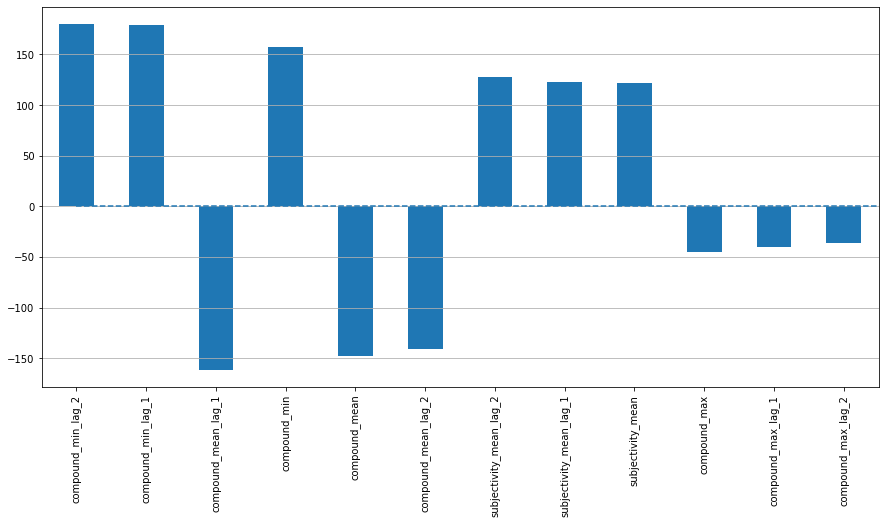

In [77]:
plotCoef(ridge_n['model'], X_train_n)

coefs = ridge_n['model'].coef_
ridge_coefs = pd.DataFrame({'Coef':coefs, 'Name':list(X_train_n.columns)})

ridge_coefs["abs"]= ridge_coefs.Coef.apply(np.abs)
ridge_coefs = ridge_coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
ridge_coefs

In [78]:
mape(y_test, ridge_n.predict(X_test_n))

58.872462865184175

## Random Forest

In [79]:
rf_param = {'model__n_estimators':[10,100,300],
            'model__max_depth':[10,20,30,40],
            'model__min_samples_split':[2,5,10],
            'model__min_samples_leaf':[1,2,3],
            'model__max_features':["auto","sqrt"]}

rf = RandomForestRegressor()
pipe=Pipeline([
    ('scale',scaler),
    ('model', rf)
])

gridsearch_rf = GridSearchCV(estimator=pipe, param_grid = rf_param, scoring=scorer, 
                             cv=tscv,
                             n_jobs=4,
                             verbose=3)
gridsearch_rf.fit(X_train_n, y_train_n)

Fitting 10 folds for each of 216 candidates, totalling 2160 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('model', RandomForestRegressor())]),
             n_jobs=4,
             param_grid={'model__max_depth': [10, 20, 30, 40],
                         'model__max_features': ['auto', 'sqrt'],
                         'model__min_samples_leaf': [1, 2, 3],
                         'model__min_samples_split': [2, 5, 10],
                         'model__n_estimators': [10, 100, 300]},
             scoring=make_scorer(mean_squared_error), verbose=3)

In [87]:
rf_n = gridsearch_rf.best_estimator_

cv_score = cross_val_score(rf_n, X_train_n, y_train_n, cv=tscv, scoring=scorer)
nlp_perf = nlp_perf.append({'Model':'RF','MSE':np.mean(cv_score), 'SD':(np.std(cv_score))}, ignore_index=True)

## XGBoost

In [80]:
xgb_param = {'model__lambda':list(np.arange(1,10,1)),
             'model__alpha': list(np.arange(1,10,1)),
             }
xgb = XGBRegressor(booster='gblinear', feature_selector='shuffle', objective='reg:squarederror')

pipe = Pipeline([
    ('scale',scaler),
    ('model',xgb)
])

gridsearch_xgb = GridSearchCV(estimator=pipe,
                              param_grid = xgb_param,
                              scoring=scorer,
                              cv=tscv,
                              n_jobs=4,
                              verbose=3)

gridsearch_xgb.fit(X_train_n,y_train_n)

Fitting 10 folds for each of 81 candidates, totalling 810 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('model',
                                        XGBRegressor(base_score=None,
                                                     booster='gblinear',
                                                     callbacks=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_bytree=None,
                                                     early_stopping_rounds=None,
                                                     enable_categorical=False,
                                                     eval_metric=None,
                                                     fea...
                                                     max_cat_to_onehot=None,
                                                     max_delta_step=None,
                                                     max_depth=None,
                                                     max_leaves=None,
                                                     min_child_weight=None,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     n_estimators=100,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     predictor=None, ...))]),
             n_jobs=4,
             param_grid={'model__alpha': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'model__lambda': [1, 2, 3, 4, 5, 6, 7, 8, 9]},
             scoring=make_scorer(mean_squared_error), verbose=3)

In [88]:
xgb_n = gridsearch_xgb.best_estimator_

cv_score = cross_val_score(xgb_n, X_train_n, y_train_n, cv=tscv, scoring=scorer)
nlp_perf = nlp_perf.append({'Model':'XGB', 'MSE':np.mean(cv_score), 'SD':(np.std(cv_score))}, ignore_index=True)
xgb_n

Pipeline(steps=[('scale', StandardScaler()),
                ('model',
                 XGBRegressor(alpha=9, base_score=None, booster='gblinear',
                              callbacks=None, colsample_bylevel=None,
                              colsample_bynode=None, colsample_bytree=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_selector='shuffle', feature_types=None,
                              gamma=None, gpu_id=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, lambda=1,
                              learning_rate=None, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=None,
                              max_leaves=None, min_child_weight=None,
                              missing=nan, monotone_constraints=None,
                              n_estimators=100, n_jobs=None, ...))])

In [89]:
print(nlp_perf)

   Model           MSE            SD
0  Ridge  8.058768e+06  6.730189e+06
1     RF  8.338721e+06  7.086198e+06
2    XGB  8.048452e+06  6.693358e+06


In [90]:
nlp_fig = px.scatter(nlp_perf, x="Model", y="MSE", color = "Model",error_y="SD")
nlp_fig.show()

# Econ + NLP Models

In [92]:
econ_cols

['Close_lag_1', 'Close_lag_2', 'Close_lag_3', 'Close_lag_4']

## Ridge regression

In [91]:
en_perf = pd.DataFrame(columns = ['Model','MSE','SD'])
en_perf

,Model,MSE,SD


In [93]:
ridge_param = {'model__alpha':list(np.arange(0.1,1,0.01))}
ridge = Ridge(max_iter=5000)
pipe = Pipeline([
    ('scale',scaler),
    ('model',ridge)
])

search_ridge=GridSearchCV(estimator=pipe,
                          param_grid = ridge_param,
                          scoring=scorer,
                          cv=tscv,
                          n_jobs=4,
                          verbose=3)
search_ridge.fit(X_train,y_train)

Fitting 10 folds for each of 90 candidates, totalling 900 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('model', Ridge(max_iter=5000))]),
             n_jobs=4,
             param_grid={'model__alpha': [0.1, 0.11, 0.12, 0.13,
                                          0.13999999999999999,
                                          0.14999999999999997,
                                          0.15999999999999998,
                                          0.16999999999999998,
                                          0.17999999999999997,
                                          0.18999999999999995,
                                          0....
                                          0.23999999999999994,
                                          0.24999999999999992,
                                          0.2599999999999999,
                                          0.2699999999999999,
                                          0.2799999999999999,
                                          0.2899999999999999,
                                          0.29999999999999993,
                                          0.30999999999999994,
                                          0.3199999999999999,
                                          0.32999999999999985,
                                          0.33999999999999986,
                                          0.34999999999999987,
                                          0.3599999999999999,
                                          0.3699999999999999,
                                          0.3799999999999999,
                                          0.3899999999999999, ...]},
             scoring=make_scorer(mean_squared_error), verbose=3)

In [94]:
ridge_en = search_ridge.best_estimator_

cv_score = cross_val_score(ridge_en, X_train, y_train, cv=tscv, scoring=scorer)
en_perf=en_perf.append({'Model':'Ridge', 'MSE':np.mean(cv_score), 'SD':(np.std(cv_score))}, ignore_index=True)
ridge_en

Pipeline(steps=[('scale', StandardScaler()),
                ('model', Ridge(alpha=0.9899999999999995, max_iter=5000))])

In [95]:
coefs = ridge_en['model'].coef_
ridge_coefs = pd.DataFrame({'Coef': coefs, 'Name':list(X_train.columns)})
ridge_coefs["abs"] = ridge_coefs.Coef.apply(np.abs)
ridge_coefs = ridge_coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
ridge_coefs

,Coef,Name
12,2041.731630,Close_lag_1
13,416.135560,Close_lag_2
15,58.640549,Close_lag_4
14,28.441285,Close_lag_3
9,8.546658,compound_min_lag_2
0,7.510668,compound_mean
7,6.159706,compound_max_lag_2
1,-5.196641,compound_max
10,-2.555332,subjectivity_mean_lag_1
5,-2.540515,compound_mean_lag_2


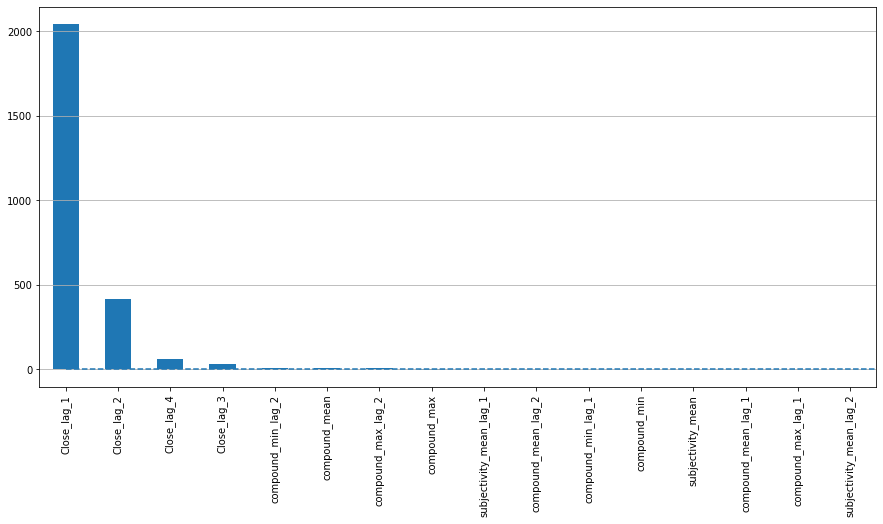

In [96]:
plotCoef(ridge_en["model"], X_train)

## Random Forest

In [97]:
rf_param = {'model__n_estimators':[10,100,300],
            'model__max_depth':[10,20,30,40],
            'model__min_samples_split':[2,5,10],
            'model__min_samples_leaf':[1,2,3],
            'model__max_features':["auto","sqrt"]}
rf = RandomForestRegressor()
pipe=Pipeline([
    ('scale',scaler),
    ('model',rf)
])

gridsearch_rf = GridSearchCV(estimator=pipe,
                             param_grid=rf_param,
                             scoring=scorer,
                             cv=tscv,
                             n_jobs=4,
                             verbose=3
                             )
gridsearch_rf.fit(X_train,y_train)

Fitting 10 folds for each of 216 candidates, totalling 2160 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('model', RandomForestRegressor())]),
             n_jobs=4,
             param_grid={'model__max_depth': [10, 20, 30, 40],
                         'model__max_features': ['auto', 'sqrt'],
                         'model__min_samples_leaf': [1, 2, 3],
                         'model__min_samples_split': [2, 5, 10],
                         'model__n_estimators': [10, 100, 300]},
             scoring=make_scorer(mean_squared_error), verbose=3)

In [98]:
rf_en = gridsearch_rf.best_estimator_

cv_score=cross_val_score(rf_en, X_train, y_train, cv=tscv, scoring=scorer)
en_perf = en_perf.append({'Model':'RF', 'MSE':np.mean(cv_score), 'SD':(np.std(cv_score))}, ignore_index=True)
rf_en

Pipeline(steps=[('scale', StandardScaler()),
                ('model',
                 RandomForestRegressor(max_depth=20, max_features='sqrt',
                                       min_samples_leaf=3, min_samples_split=10,
                                       n_estimators=10))])

## XGBoost

In [99]:
xgb_param={'model__lambda':list(np.arange(1,10,1)),
           'model__alpha':list(np.arange(1,10,1)),
           }
xgb = XGBRegressor(booster='gblinear', feature_selector='shuffle', objective='reg:squarederror')

pipe=Pipeline([
    ('scale',scaler),
    ('model',xgb)
])

girdsearch_xgb=GridSearchCV(estimator=pipe,
                            param_grid=xgb_param,
                            scoring=scorer,
                            cv=tscv,
                            n_jobs=4,
                            verbose=3)
gridsearch_xgb.fit(X_train,y_train)

Fitting 10 folds for each of 81 candidates, totalling 810 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('model',
                                        XGBRegressor(base_score=None,
                                                     booster='gblinear',
                                                     callbacks=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_bytree=None,
                                                     early_stopping_rounds=None,
                                                     enable_categorical=False,
                                                     eval_metric=None,
                                                     fea...
                                                     max_cat_to_onehot=None,
                                                     max_delta_step=None,
                                                     max_depth=None,
                                                     max_leaves=None,
                                                     min_child_weight=None,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     n_estimators=100,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     predictor=None, ...))]),
             n_jobs=4,
             param_grid={'model__alpha': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'model__lambda': [1, 2, 3, 4, 5, 6, 7, 8, 9]},
             scoring=make_scorer(mean_squared_error), verbose=3)

In [100]:
xgb_en = gridsearch_xgb.best_estimator_

cv_score = cross_val_score(xgb_en, X_train, y_train, cv=tscv, scoring=scorer)
en_perf = en_perf.append({"Model":"XGB", 'MSE':np.mean(cv_score), 'SD':(np.std(cv_score))}, ignore_index=True)
xgb_en

Pipeline(steps=[('scale', StandardScaler()),
                ('model',
                 XGBRegressor(alpha=9, base_score=None, booster='gblinear',
                              callbacks=None, colsample_bylevel=None,
                              colsample_bynode=None, colsample_bytree=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_selector='shuffle', feature_types=None,
                              gamma=None, gpu_id=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, lambda=9,
                              learning_rate=None, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=None,
                              max_leaves=None, min_child_weight=None,
                              missing=nan, monotone_constraints=None,
                              n_estimators=100, n_jobs=None, ...))])

# Try Stacking econometric and NLP Models

In [102]:
from sklearn.model_selection import cross_val_predict

X_train_stack = pd.DataFrame(pd.DataFrame(columns=['econ_r','nlp_r']))
X_train_stack['econ_r'] = cross_val_predict(ridge_e, X_train_e, y_train,cv=10)
X_train_stack['nlp_r'] = cross_val_predict(ridge_n, X_train_n, y_train,cv=10)

X_test_stack = pd.DataFrame(pd.DataFrame(columns=['econ_r', 'nlp_r']))
X_test_stack['econ_r'] = ridge_e.predict(X_test_e)
X_test_stack['nlp_r'] = ridge_n.predict(X_test_n)

In [103]:
from sklearn.linear_model import ElasticNetCV

stack = ElasticNetCV(cv=tscv)
stack.fit(X_train_stack, y_train)

cv_score = cross_val_score(stack, X_train_stack, y_train, cv=tscv, scoring=scorer)
stack_performance = {'Model':'XGB', 'MSE':np.mean(cv_score), 'SD':(np.std(cv_score))}
stack_performance

mape(y_test,stack.predict(X_test_stack))

1.4284199127652224

      Coef    Name
0  0.99867  econ_r
1 -0.00000   nlp_r


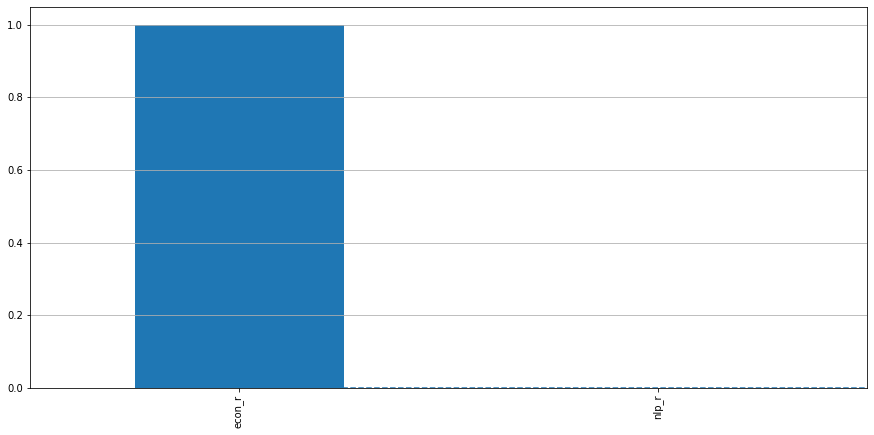

In [104]:
coefs = stack.coef_
ridge_coefs = pd.DataFrame({'Coef':coefs,'Name':list(X_train_stack.columns)})
ridge_coefs["abs"]= ridge_coefs.Coef.apply(np.abs)
ridge_coefs = ridge_coefs.sort_values(by="abs", ascending=False).drop(["abs"],axis=1)
print(ridge_coefs)
plotCoef(stack, X_train_stack)

# Model Comparison

In [106]:
prediction_compare = pd.DataFrame(pd.DataFrame(columns=['y_true','econ_r', 'econ_rf', 'econ_x','nlp_r','nlp_rf','nlp_x','comb_r','comb_rf','comb_x','stack']))

prediction_compare['y_true'] = y_test

prediction_compare['econ_r'] = ridge_e.predict(X_test_e)
prediction_compare['econ_rf'] = rf_e.predict(X_test_e)
prediction_compare['econ_x'] = xgb_e.predict(X_test_e)

prediction_compare['nlp_r'] = ridge_n.predict(X_test_n)
prediction_compare['nlp_rf'] = rf_n.predict(X_test_n)
prediction_compare['nlp_x'] = xgb_n.predict(X_test_n)

prediction_compare['comb_r'] = ridge_en.predict(X_test)
prediction_compare['comb_rf'] = rf_en.predict(X_test)
prediction_compare['comb_x'] = xgb_en.predict(X_test)

#ElasticNET
prediction_compare['stack'] = stack.predict(X_test_stack)

prediction_compare.sample(3)

,y_true,econ_r,econ_rf,econ_x,nlp_r,nlp_rf,nlp_x,comb_r,comb_rf,comb_x,stack
1782,8500.330078,8725.378286,9937.127723,11153.851562,13930.779129,15792.160597,14253.744141,8721.212951,10081.120755,12700.064453,8733.136100
1925,9325.009766,9353.131659,9937.127723,11427.791992,14415.258397,14555.835377,14456.078125,9385.290491,9987.226143,12870.139648,9360.054353
1795,8418.769531,8433.832765,9937.127723,10932.254883,14642.835779,14748.469519,14535.767578,8430.374579,10109.596453,12616.042969,8441.978432
